**Imports**

In [1]:
# Standard Imports
import random

# 3rd Party
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from pgmpy.estimators import PC
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Synthcity
from synthcity.plugins.core.dataloader import GenericDataLoader

# Goggle
from goggle.GoggleModel import GoggleModel

/home/rob/miniconda3/envs/goggle10/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-03-07 16:02:33,438 - Created a temporary directory at /tmp/tmpjustwu6f
2023-03-07 16:02:33,438 - Writing /tmp/tmpjustwu6f/_remote_module_non_scriptable.py


**Load data**

In [2]:
dataset = "credit"
X = pd.read_csv("../data/german_credit_2.csv")
target = X.pop("Creditability")
X["target"] = target - 1.0
X = X.dropna(axis=0)
ind = list(range(len(X.columns)))
ind = [x for x in ind if x != X.columns.get_loc("target")]
col_list = X.columns[ind]

ct = ColumnTransformer(
    [("scaler", StandardScaler(), col_list)], remainder="passthrough"
)

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X.head()

,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8,Attribute 9,Attribute 10,...,Attribute 16,Attribute 17,Attribute 18,Attribute 19,Attribute 20,Attribute 21,Attribute 22,Attribute 23,Attribute 24,target
0,-1.254566,-1.236478,1.344014,-0.733432,1.833169,1.338078,0.449326,1.046987,-1.293723,2.766456,...,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,-0.5,0.766356,0.0
1,-0.459026,2.248194,-0.503428,0.966377,-0.699707,-0.317959,-0.963650,-0.765977,-1.293723,-1.191404,...,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,-0.5,0.766356,1.0
2,1.132053,-0.738668,1.344014,-0.414718,-0.699707,0.510060,0.449326,0.140505,-1.293723,1.183312,...,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,2.0,-1.304877,0.0
3,-1.254566,1.750384,-0.503428,1.639217,-0.699707,0.510060,0.449326,1.046987,-0.341055,0.831502,...,-0.552705,-0.338862,-3.122929,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,0.766356,0.0
4,-1.254566,0.256953,0.420293,0.576837,-0.699707,-0.317959,0.449326,1.046987,1.564281,1.535122,...,1.809283,-0.338862,0.320212,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,0.766356,1.0


**Specify ablation settings**

In [3]:
def get_adj_mat(adj_type, X, n):
    if adj_type == "ER":
        m = int(n**2 * 0.1)
        G = nx.gnm_random_graph(n, m)
        adj_mat = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if (i, j) in list(G.edges):
                    adj_mat[i][j] = 1
    elif adj_type == "COV":
        adj_mat = abs(np.corrcoef(X.to_numpy().T))
    elif adj_type == "BN":
        c = PC(X)
        model = c.estimate(variant="parallel", max_cond_vars=3, ci_test="pearsonr")
        adj_mat = np.zeros((n, n))
        for i, col_name_i in enumerate(X.columns):
            for j, col_name_j in enumerate(X.columns):
                if (col_name_i, col_name_j) in model.edges():
                    adj_mat[i][j] = 1
    else:
        adj_mat = np.ones((n, n))

    plt.figure(figsize=(4, 4))
    im = plt.imshow(adj_mat, cmap="inferno", interpolation="nearest", vmin=0, vmax=1.0)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Prior graph")
    plt.axis("off")
    plt.show()
    return adj_mat

**Fit model - compare ablation settings**

Considering ablation setting: ER


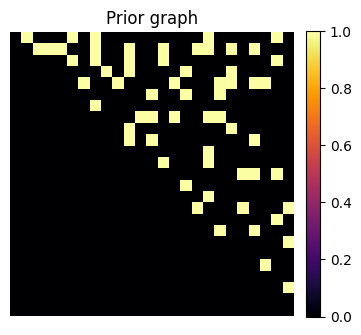

[Epoch 100/1000, patience 29] train: 23.543, val: 23.210
Training terminated after 156 epochs
Quality: 0.288
Detection: 0.776
Performance on real: 0.624, on synth: 0.516, diff: 0.108
Considering ablation setting: COV


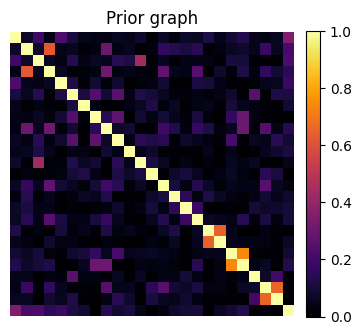

[Epoch 100/1000, patience 33] train: 23.529, val: 23.199
Training terminated after 164 epochs
Quality: 0.281
Detection: 0.797
Performance on real: 0.624, on synth: 0.519, diff: 0.105
Considering ablation setting: BN


Working for n conditional variables: 3: 100%|██████████| 3/3 [00:02<00:00,  1.02s/it]

2023-03-07 16:03:58,080 - Reached maximum number of allowed conditional variables. Exiting


Working for n conditional variables: 3: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


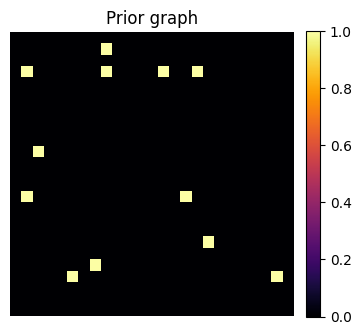

[Epoch 100/1000, patience 33] train: 23.522, val: 23.199
[Epoch 200/1000, patience 22] train: 23.516, val: 23.191
[Epoch 300/1000, patience 30] train: 23.530, val: 23.206
Training terminated after 319 epochs
Quality: 0.313
Detection: 0.864
Performance on real: 0.624, on synth: 0.460, diff: 0.163
Considering ablation setting: DENSE


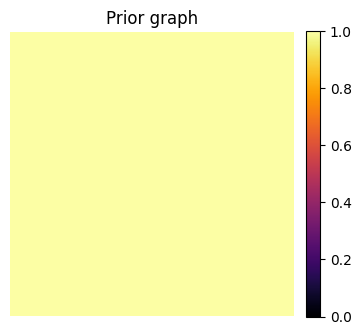

[Epoch 100/1000, patience 33] train: 23.532, val: 23.202
Training terminated after 164 epochs
Quality: 0.291
Detection: 0.839
Performance on real: 0.624, on synth: 0.506, diff: 0.118


In [4]:
X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)

for adj_type in ["ER", "COV", "BN", "DENSE"]:
    print(f"\n\nConsidering ablation setting: {adj_type}")
    adj_mat = get_adj_mat(adj_type, X, n=X_train.shape[1])
    gen = GoggleModel(
        ds_name=dataset,
        input_dim=X_train.shape[1],
        encoder_dim=64,
        encoder_l=2,
        het_encoding=True,
        decoder_dim=64,
        decoder_l=2,
        threshold=0.1,
        het_decoder=False,
        graph_prior=torch.Tensor(adj_mat),
        prior_mask=torch.ones_like(torch.Tensor(adj_mat)),
        device="cpu",
        beta=0.1,
        seed=0,
    )
    gen.fit(X_train)
    X_synth = gen.sample(X_test)

    X_synth_loader = GenericDataLoader(
        X_synth,
        target_column="target",
    )
    X_test_loader = GenericDataLoader(
        X_test,
        target_column="target",
    )

    res = gen.evaluate_synthetic(X_synth_loader, X_test_loader)
    print(f"Quality: {res[0]:.3f}")
    print(f"Detection: {res[2]:.3f}")
    print(
        f"Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}, diff: {(res[1][0] - res[1][1]):.3f}"
    )